In [2]:
!pip install gsw -q

In [3]:
!pip install gcm-filters -q

# Dask start

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34047")

# Import

In [5]:
import sys
sys.path.insert(1, '..')

In [6]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm

# Plotting params

In [8]:
#%matplotlib widget
%matplotlib inline

In [9]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [10]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [11]:
data=[dict() for i in range(1)]

In [12]:
# data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
# data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[0] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
#data[0] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
# data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
# data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [13]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [14]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,100),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [15]:
chunk_dict = {'x' : 152, 'y' : 184, 'deptht' : -1}

In [16]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='interior_daily', season=data[i]['season']).to_dask()
    #drop(['vovecrtz', 'vomecrty', 'vozocrtx'],errors='ignore')
    current_set = current_set.chunk(chunk_dict)
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk(chunk_dict)
    data[i]['HR'] = current_set

CPU times: user 6.82 s, sys: 2.07 s, total: 8.89 s
Wall time: 23 s


In [17]:
current_set = data[0]['HR'] 

In [18]:
current_set

<xarray.Dataset>
Dimensions:       (y: 734, x: 606, deptht: 107, depthu: 107, depthv: 107,
                   depthw: 107, time_counter: 1)
Coordinates: (12/19)
    depth         (y, x) float32 dask.array<chunksize=(184, 152), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(184, 152), meta=np.ndarray>
    ...            ...
    lat           (y, x) float32 dask.array<chunksize=(184, 152), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(184, 152), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(184, 152), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(184, 152), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01
    tmask         (deptht, y, x) float32 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    umask         (depthu, y, x) int8 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    vmask         (depthv, y, x) int8 dask.array<chunksize=(107, 184, 152), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(1, 107, 184, 152), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 107, 184, 152), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 107, 184, 152), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 107, 184, 152), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(1, 107, 184, 152), meta=np.ndarray>

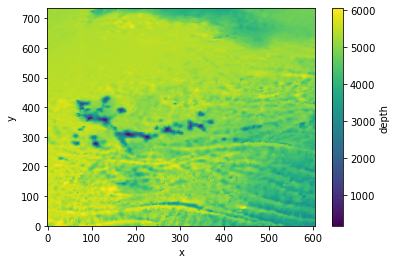

In [21]:
current_set.depth.plot()

# Grid metrics

In [22]:
ds = xr.Dataset({},
               coords={"x_c": np.arange(len(current_set['x'])),\
                       "y_c": np.arange(len(current_set['y'])) ,\
                       "x_f": np.arange(0.5,0.5+len(current_set['x']),1.),\
                       "y_f": np.arange(0.5,0.5+len(current_set['y']),1.),\
                       "z_c": current_set['deptht'].values,\
                       "z_f": current_set['depthw'].values,\
                       # "z_c": np.arange(len(current_set['deptht'])),\
                       # "z_f": np.arange(0.5,0.5+len(current_set['deptht']),1.),\
                      })

In [23]:
chunk_dict = {'x_c' : 152, 'y_c' : 184, 'z_c' : -1, 'x_f' : 152, 'y_f' : 184, 'z_f' : -1}

In [24]:
ds.coords['e1t'] = xr.DataArray(current_set.coords['e1t'].values, dims=['y_c', 'x_c'])
ds.coords['e2t'] = xr.DataArray(current_set.coords['e2t'].values, dims=['y_c', 'x_c'])
ds.coords['e3t'] = xr.DataArray(current_set['e3t_0'].values, dims=['z_c', 'y_c', 'x_c'])
ds.coords['tmask'] = xr.DataArray(current_set['tmask'].values, dims=['z_c', 'y_c', 'x_c'])

ds.coords['e1u'] = xr.DataArray(current_set.coords['e1u'].values, dims=['y_c', 'x_f'])
ds.coords['e2u'] = xr.DataArray(current_set.coords['e2u'].values, dims=['y_c', 'x_f'])
ds.coords['e3u'] = xr.DataArray(current_set['e3u_0'].values, dims=['z_c', 'y_c', 'x_f'])
ds.coords['umask'] = xr.DataArray(current_set['umask'].values, dims=['z_c', 'y_c', 'x_f'])

ds.coords['e1v'] = xr.DataArray(current_set.coords['e1v'].values, dims=['y_f', 'x_c'])
ds.coords['e2v'] = xr.DataArray(current_set.coords['e2v'].values, dims=['y_f', 'x_c'])
ds.coords['e3v'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_f', 'x_c'])
ds.coords['vmask'] = xr.DataArray(current_set['vmask'].values, dims=['z_c', 'y_f', 'x_c'])

ds.coords['e1f'] = xr.DataArray(current_set.coords['e1f'].values, dims=['y_f', 'x_f'])
ds.coords['e2f'] = xr.DataArray(current_set.coords['e2f'].values, dims=['y_f', 'x_f'])
#ds.coords['e3f'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_f', 'x_f'])
ds.coords['fmask'] = xr.DataArray(current_set['fmask'].values, dims=['z_c', 'y_f', 'x_f'])

ds.coords['e3w'] = xr.DataArray(current_set['e3w_0'].values, dims=['z_f', 'y_c', 'x_c'])

ds.coords['depth'] = xr.DataArray(current_set['depth'].values, dims=['y_c', 'x_c'])
ds.coords['lat'] = xr.DataArray(current_set['lat'].values, dims=['y_c', 'x_c'])
ds.coords['lon'] = xr.DataArray(current_set['lon'].values, dims=['y_c', 'x_c'])

In [25]:
ds = ds.chunk(chunk_dict)

In [26]:
ds['vosaline'] = current_set['vosaline'].\
reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'tmask'], drop=True).\
reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
rename(deptht = 'z_c', y='y_c', x='x_c')
ds['votemper'] = current_set['votemper'].\
reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'tmask'], drop=True).\
reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
rename(deptht = 'z_c', y='y_c', x='x_c')

In [27]:
ds['vozocrtx'] = current_set['vozocrtx'].\
reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], drop=True).\
reindex(depthu = ds.z_c.values, y = ds.y_c.values, x = ds.x_f.values, method='bfill').\
rename(depthu = 'z_c', y='y_c', x='x_f')

ds['vomecrty'] = current_set['vomecrty'].\
reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], drop=True).\
reindex(depthv = ds.z_c.values, y = ds.y_f.values, x = ds.x_c.values, method='bfill').\
rename(depthv = 'z_c', y='y_f', x='x_c')

ds['vovecrtz'] = current_set['vovecrtz'].\
reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], drop=True).\
reindex(depthw = ds.z_f.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
rename(depthw = 'z_f', y='y_c', x='x_c')

In [28]:
ds['area'] = ds['e1t']*ds['e2t']

In [29]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    ('X', 'Y',): ['area'] # Areas 
}

In [30]:
grid = xgcm.Grid(ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c', 'right' : 'x_f'}, \
                                                              'Y' : {'center' : 'y_c', 'right' : 'y_f'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_f'}})

In [31]:
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_f --> center

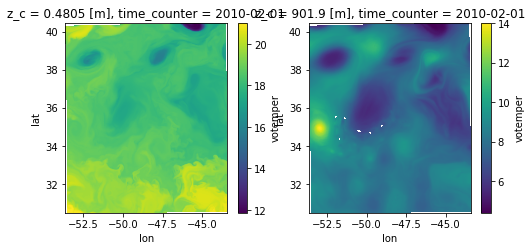

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5))
ds.votemper.isel(time_counter=0, z_c=0).plot(x='lon', y='lat', ax=ax[0])
ds.votemper.isel(time_counter=0, z_c=100).plot(x='lon', y='lat', ax=ax[1])
plt.show()

# Density

Compute sea pressure

In [33]:
# NOT to forget minus in front of z
ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.z_c, ds.lat, dask='parallelized')

Compute density

In [34]:
ds['rho'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
ds['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')

## Vertical profiles

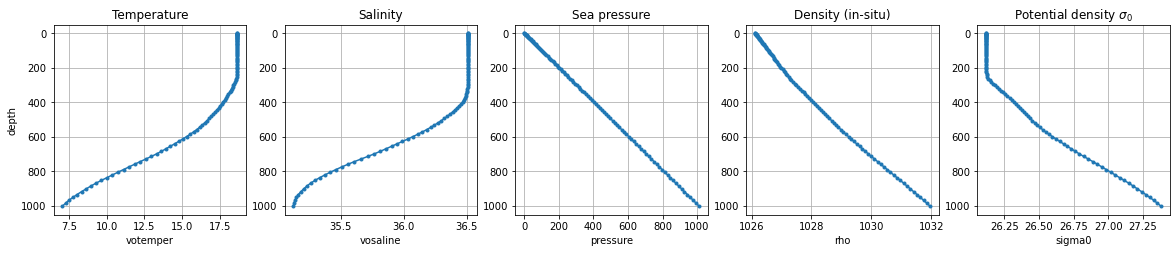

In [35]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,3.5))
ds['votemper'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[0],y='z_c', marker='.')
ds['vosaline'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[1],y='z_c', marker='.')
ds['pressure'].isel(x_c=200, y_c=200).plot(ax=ax[2],y='z_c', marker='.')
ds['rho'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[3],y='z_c', marker='.')
ds['sigma0'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[4],y='z_c', marker='.')
ax[0].set(title='Temperature')
ax[1].set(title='Salinity')
ax[2].set(title='Sea pressure')
ax[3].set(title='Density (in-situ)')
ax[4].set(title=r'Potential density $\sigma_0$')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

## Horizontal gradients

In [36]:
ds['dx_rho'] = grid.derivative(ds.rho, axis='X', boundary='extend')
ds['dy_rho'] = grid.derivative(ds.rho, axis='Y', boundary='extend')

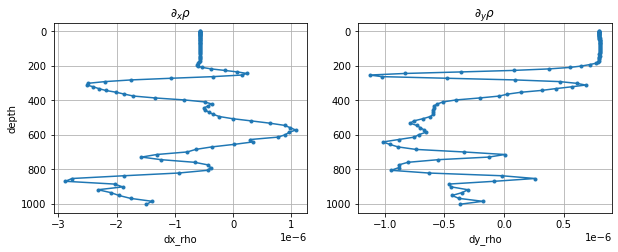

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
ds['dx_rho'].isel(time_counter=0, x_f=200, y_c=200).plot(ax=ax[0],y='z_c', marker='.')
ds['dy_rho'].isel(time_counter=0, x_c=200, y_f=200).plot(ax=ax[1],y='z_c', marker='.')
ax[0].set(title=r'$\partial_x \rho $')
ax[1].set(title=r'$\partial_y \rho $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

# Horizontal pressure gradient

In [38]:
g = 9.80665 
rho_0 = 1023.6

In [86]:
# ds['dx_p'] = g/rho_0*grid.cumint(grid.interp(ds.dx_rho, axis=['X', 'Z'], boundary='extend'), axis='Z')
# ds['dy_p'] = g/rho_0*grid.cumint(grid.interp(ds.dy_rho, axis=['Y', 'Z'], boundary='extend'), axis='Z')

ds['dx_p'] = g/rho_0*grid.cumsum(grid.interp(ds.dx_rho, axis=['X', 'Z'], boundary='extend')*ds.e3w, axis='Z')
ds['dy_p'] = g/rho_0*grid.cumsum(grid.interp(ds.dy_rho, axis=['Y', 'Z'], boundary='extend')*ds.e3w, axis='Z')

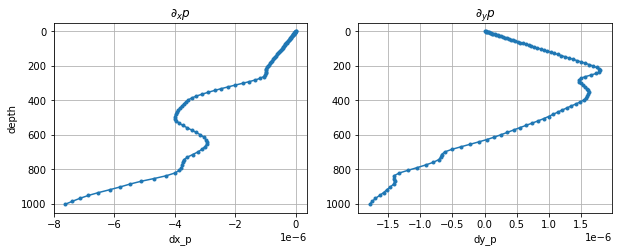

In [87]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
ds['dx_p'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[0],y='z_c', marker='.')
ds['dy_p'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[1],y='z_c', marker='.')
ax[0].set(title=r'$\partial_x p $')
ax[1].set(title=r'$\partial_y p $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

# Geostrophy

In [88]:
# Coriolis parameter
ds['f'] = xr.apply_ufunc(gsw.geostrophy.f, ds.lat, dask='parallelized')

In [89]:
x0=300
y0=300

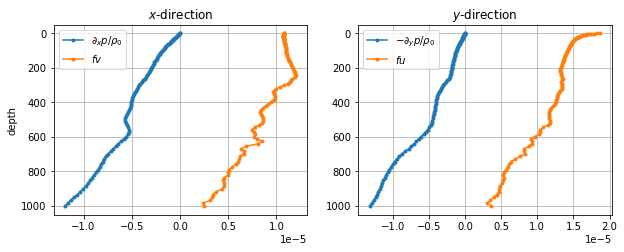

In [90]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
ds['dx_p'].isel(x_c=x0,y_c=y0).mean(dim='time_counter').plot(ax=ax[0],y='z_c', marker='.', label=r'$\partial_x p/\rho_0$')
(-ds['dy_p']).isel(x_c=x0,y_c=y0).mean(dim='time_counter').plot(ax=ax[1],y='z_c', marker='.', label=r'$-\partial_y p/\rho_0$')
(grid.interp(ds.f, axis='Y', boundary='extend')*ds['vomecrty']).isel(x_c=x0,y_f=y0).mean(dim='time_counter').plot(ax=ax[0],y='z_c', marker='.', label=r'$f v$')
(grid.interp(ds.f, axis='X', boundary='extend')*ds['vozocrtx']).isel(x_f=x0,y_c=y0).mean(dim='time_counter').plot(ax=ax[1],y='z_c', marker='.', label=r'$f u$')
ax[0].set(title=r'$x$-direction')
ax[1].set(title=r'$y$-direction')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
    axis.legend()
ax[0].set(ylabel='depth')
plt.show()

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1637: UserWarning: Metric at ('y_f', 'x_c', 'time_counter', 'z_c') being interpolated from metrics at dimensions ('y_c', 'x_c'). Boundary value set to 'extend'.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1637: UserWarning: Metric at ('y_c', 'x_f', 'time_counter', 'z_c') being interpolated from metrics at dimensions ('y_c', 'x_c'). Boundary value set to 'extend'.
  warnings.warn(


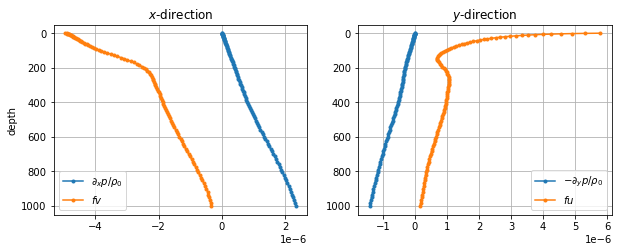

In [91]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
grid.average(ds['dx_p'], axis=['X', 'Y']).mean(dim='time_counter').plot(ax=ax[0],y='z_c', marker='.', label=r'$\partial_x p/\rho_0$')
grid.average(-ds['dy_p'], axis=['X', 'Y']).mean(dim='time_counter').plot(ax=ax[1],y='z_c', marker='.', label=r'$-\partial_y p/\rho_0$')
grid.average(grid.interp(ds.f, axis='Y', boundary='extend')*ds['vomecrty'], axis=['X', 'Y']).mean(dim='time_counter').plot(ax=ax[0],y='z_c', marker='.', label=r'$f v$')
grid.average(grid.interp(ds.f, axis='X', boundary='extend')*ds['vozocrtx'], axis=['X', 'Y']).mean(dim='time_counter').plot(ax=ax[1],y='z_c', marker='.', label=r'$f u$')
ax[0].set(title=r'$x$-direction')
ax[1].set(title=r'$y$-direction')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
    axis.legend()
ax[0].set(ylabel='depth')
plt.show()

In [48]:
#grid.average(ds['votemper'], axis=['X', 'Y'])

# EOS density derivatives

In [81]:
# problem with implementation of second serivatives in gsw: does not work with xarray output
temp_array = gsw.rho_second_derivatives(ds.vosaline.values, ds.votemper.values, ds.pressure.values)
ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['time_counter','z_c', 'y_c', 'x_c'])
ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['time_counter','z_c', 'y_c', 'x_c'])
ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['time_counter','z_c', 'y_c', 'x_c'])
ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['time_counter','z_c', 'y_c', 'x_c'])
ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['time_counter','z_c', 'y_c', 'x_c'])

del temp_array

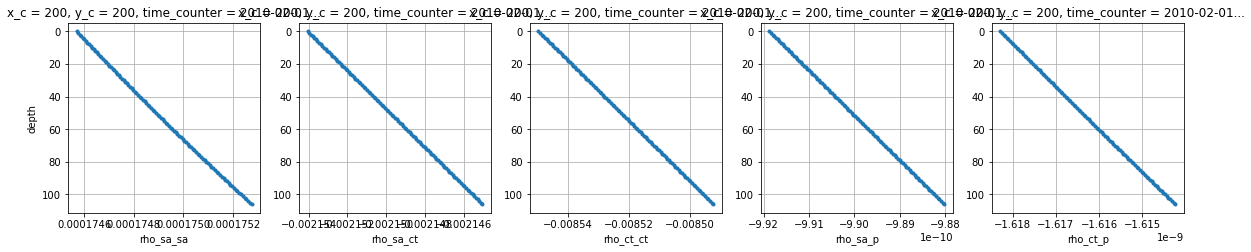

In [82]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,3.5))
ds['rho_sa_sa'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[0],y='z_c', marker='.')
ds['rho_sa_ct'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[1],y='z_c', marker='.')
ds['rho_ct_ct'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[2],y='z_c', marker='.')
ds['rho_sa_p'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[3],y='z_c', marker='.')
ds['rho_ct_p'].isel(time_counter=0, x_c=200, y_c=200).plot(ax=ax[4],y='z_c', marker='.')
#ds['dy_p'].isel(time_counter=0, x_c=200, y_f=200).plot(ax=ax[1],y='z_c', marker='.')
#ax[0].set(title=r'$\partial_x p $')
#ax[1].set(title=r'$\partial_y p $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()